In [1]:
%load_ext autoreload

import sys
project_path = "/media/HDD_3TB/marc/food_ingredients_recognition"
sys.path.append(project_path)
sys.path.append("/media/HDD_3TB/marc/multimodal_keras_wrapper")

from model import Ingredients_Model
from data_engine.prepare_data import build_dataset

from keras.models import *

from keras_wrapper.cnn_model import loadModel, saveModel, transferWeights
from keras_wrapper.dataset import loadDataset
from keras_wrapper.extra.evaluation import *
from keras_wrapper.utils import decode_multilabel

# Plot libraries
from matplotlib.patches import Rectangle
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
from PIL import Image as pilimage
from scipy import ndimage
from IPython.display import HTML, display
import shutil
import plotly

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)
25/05/2017_17:14:54:  Log file (/home/lifelogging/.picloud/cloud.log) opened


In [4]:
%autoreload 2

from config_UNIMIB2016 import load_parameters

# Load basic dataset
params = load_parameters()
params['REBUILD_DATASET'] = True
params['STORE_PATH'] = project_path+'/'+params['STORE_PATH']
dataset = build_dataset(params)

25/05/2017_17:19:28:  Building Food_UNIMIB2016 dataset
25/05/2017_17:19:28:  Loaded "train" set inputs of type "raw-image" with id "image" and length 650.
25/05/2017_17:19:28:  Loaded "val" set inputs of type "raw-image" with id "image" and length 650.
25/05/2017_17:19:28:  Loaded "test" set inputs of type "raw-image" with id "image" and length 360.
25/05/2017_17:19:28:  Converting input train mean pixels into mean image.
25/05/2017_17:19:28:  Preprocessing list of ingredients for assigning vocabulary as image classes.
25/05/2017_17:19:28:  Loaded "train" set outputs of type "binary" with id "ingredients" and length 650.
25/05/2017_17:19:28:  Loaded "val" set outputs of type "binary" with id "ingredients" and length 650.
25/05/2017_17:19:28:  Loaded "test" set outputs of type "binary" with id "ingredients" and length 360.
25/05/2017_17:19:28:  <<< Saving Dataset instance to /media/HDD_3TB/marc/food_ingredients_recognition/trained_models/Inception__UNIMIB2016/Dataset_Food_UNIMIB2016.pkl

## Model loading

In [5]:
%autoreload 2

# Load initial model
model = loadModel(params['STORE_PATH'], params['RELOAD'])

25/05/2017_17:19:34:  <<< Loading model from /media/HDD_3TB/marc/food_ingredients_recognition/trained_models/Inception__UNIMIB2016/epoch_194_Model_Wrapper.pkl ... >>>
25/05/2017_17:19:38:  <<< Model loaded in 3.0568 seconds. >>>


## Data loading

In [6]:
def plotSamples(sample_imgs, dataset, width='300px', per_row=3, raw2clean=None):

    count_plotted = 1
   
    # Load data
    [Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, sample_imgs, debug=True)

    # Load GT
    gt = decode_multilabel(Ydeb[0],
                           dataset.extra_variables['idx2word_binary'],
                           min_val=params['MIN_PRED_VAL'], verbose=0)
    
    
    # Convert ingredients to clean/basic version
    #print 'gt before',gt
    if raw2clean is not None:
        raw2clean, clean_list = raw2clean
        
        GT = []
        for g in gt:
            this_g = []
            for g_ in g:
                this_g.append(clean_list[raw2clean[g_.strip()]])
            GT.append(this_g)
        gt = GT
    #print 'gt after',gt
    
    max_plot_num = 100*per_row
    display_txt = '<tr>'


    labels_row = []
    colours_row = []
    gt_row = []
    dishes_row = []
    sub_count_plotted = 1
    for i, (im, g) in enumerate(zip(Xdeb[0], gt)):
        dish = im.split('/')[0]
        dishes_row.append(dish)

        
        try:
            tmp_path = 'tmp/'+str(count_plotted)+'.jpg'
            shutil.copyfile(dataset.path+'/'+im+'.jpg', tmp_path)
        except:    
            tmp_path = 'tmp/'+str(count_plotted)+'.jpg'
            shutil.copyfile(dataset.path+'/'+im, tmp_path)

        # plot image
        display_txt += '<td style="border: 0px; padding=1em; width: '+width+';"><img src="'+tmp_path+'?'+str(np.random.rand())+'" style="width: '+width+'; padding: 1em;"/></td>'
        gt_row.append(g)

        if sub_count_plotted%per_row == 0 or i+1 == len(Xdeb[0]):

            display_txt += '</tr><tr>'

            # Plot GT
            for g in gt_row:
                display_txt += '<td style="border: 0px; padding=1em; text-align: center; width: '+width+';"><b>Ingredients</b>:'
                for g_ in g:
                    display_txt += '<span> \''+g_+'\'</span>,'
                display_txt += '</td>'

            display_txt += '</tr><tr>'

            gt_row = []
            dishes_row = []

        count_plotted += 1
        count_plotted = count_plotted%max_plot_num

        sub_count_plotted += 1

    display_txt += '</tr>'
    
    display(HTML(display_txt))

/home/lifelogging/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:

 This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




In [13]:
def plotIngredientsRecognition(sample_imgs, model, dataset, width='300px', per_row=3, raw2clean=None, min_val_pred=None):

    count_plotted = 1
    
    if min_val_pred is None:
        min_val = params['MIN_PRED_VAL']
    else:
        min_val = min_val_pred
   
    # Load data
    [X, Y] = dataset.getXY_FromIndices(set_split, sample_imgs, dataAugmentation=False)
    [Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, sample_imgs, debug=True)
    
    # Apply prediction
    pred = model.model.predict(X)
    predictions = decode_multilabel(pred,
                                    dataset.extra_variables['idx2word_binary'],
                                    min_val=min_val, verbose=0)

    # Load GT
    gt = decode_multilabel(Ydeb[0],
                           dataset.extra_variables['idx2word_binary'],
                           min_val=params['MIN_PRED_VAL'], verbose=0)
    
    
    # Convert ingredients to clean/basic version
    #print 'gt before',gt
    if raw2clean is not None:
        raw2clean, clean_list = raw2clean
        
        pred = []
        for p in predictions:
            this_p = []
            for p_ in p:
                this_p.append(clean_list[raw2clean[p_.strip()]])
            pred.append(this_p)
        predictions = pred
        
        GT = []
        for g in gt:
            this_g = []
            for g_ in g:
                this_g.append(clean_list[raw2clean[g_.strip()]])
            GT.append(this_g)
        gt = GT
    #print 'gt after',gt
    
    max_plot_num = 1000*per_row
    display_txt = '<tr>'


    labels_row = []
    colours_row = []
    gt_row = []
    gt_colours_row = []
    dishes_row = []
    sub_count_plotted = 1
    for i, (im, p, g) in enumerate(zip(Xdeb[0], predictions, gt)):
        dish = im.split('/')[0]
        dishes_row.append(dish)

        
        try:
            tmp_path = 'tmp/'+str(count_plotted)+'.jpg'
            shutil.copyfile(dataset.path+'/'+im+'.jpg', tmp_path)
        except:    
            tmp_path = 'tmp/'+str(count_plotted)+'.jpg'
            shutil.copyfile(dataset.path+'/'+im, tmp_path)

        # plot image
        display_txt += '<td style="border: 0px; padding=1em; width: '+width+';"><img src="'+tmp_path+'?'+str(np.random.rand())+'" style="width: '+width+'; padding: 1em;"/></td>'
        labels_row.append(p)
        gt_row.append(g)

        # calculate TP and FP predictions for colouring
        c = []
        for p_ in p:
            if p_ in g:
                c.append('#319FC4') # green (TP) #9CCF46
            else:
                c.append('#C64B31') # red (FP)
        colours_row.append(c)

        # calculate TP and FN predictions for colouring
        c = []
        for g_ in g:
            if g_ in p:
                c.append('#319FC4') # green (TP)
            else:
                c.append('#EF973D') # orange (FN)
        gt_colours_row.append(c)

        if sub_count_plotted%per_row == 0 or i+1 == len(Xdeb[0]):

            display_txt += '</tr><tr>'

            # show dish/recipe name
            for dish in dishes_row:
                dish = ' '.join(dish.split('_'))
                display_txt += '<td style="border: 0px; width: '+width+'; text-align: center;"><b>Dish</b>: '+dish+'</td>'
            display_txt += '</tr><tr>'

            # Plot predictions
            for p, c in zip(labels_row, colours_row):
                display_txt += '<td style="border: 0px; padding=1em; text-align: center; width: '+width+';"><b>Prediction</b>: '
                for p_, c_ in zip(p, c):
                    display_txt += '<span style="color: '+c_+';"> \''+p_+'\'</span>,'
                display_txt += '</td>'
            display_txt += '</tr><tr>'

            # Plot GT
            for g, c in zip(gt_row, gt_colours_row):
                display_txt += '<td style="border: 0px; padding=1em; text-align: center; width: '+width+';"><b>GT</b>: '
                for g_, c_ in zip(g, c):
                    display_txt += '<span style="color: '+c_+';"> \''+g_+'\'</span>,'
                display_txt += '</td>'

            display_txt += '</tr><tr>'

            labels_row = []
            gt_row = []
            colours_row = []
            gt_colours_row = []
            dishes_row = []

        count_plotted += 1
        count_plotted = count_plotted%max_plot_num

        sub_count_plotted += 1

    display_txt += '</tr>'
    
    display(HTML(display_txt))

In [20]:
set_split = 'test'
exec('len_split = dataset.len_'+set_split)
sample_imgs = range(9)

plotIngredientsRecognition(sample_imgs, model, dataset, width='300px', per_row=3, min_val_pred=0.001)

,,
Dish:,Dish:,Dish:
"Prediction: 'budino', 'zucchine_umido', 'pasta_sugo_vegetariano', 'mandarini', 'pizza',","Prediction: 'pasta_zafferano_e_piselli', 'patate/pure', 'pane', 'arrosto', 'riso_sugo', 'passato_alla_piemontese', 'torta_crema_2', 'carote', 'fagiolini',","Prediction: 'salmone_(da_menu_sembra_spada_in_realta)', 'pane', 'pizzoccheri', 'pere', 'pasta_pesto_besciamella_e_cornetti', 'pesce_2_(filetto)', 'merluzzo_alle_olive', 'arrosto', 'riso_sugo', 'spinaci',"
"GT: 'pasta_mare_e_monti', 'budino', 'mandarini', 'pizza',","GT: 'patate/pure', 'arrosto', 'carote', 'fagiolini',","GT: 'pane', 'pizzoccheri', 'pesce_(filetto)', 'spinaci',"
,,
Dish:,Dish:,Dish:
"Prediction: 'patate/pure', 'pane', 'pizzoccheri', 'torta_salata_spinaci_e_ricotta', 'arrosto',","Prediction: 'patate/pure', 'pane', 'pizzoccheri', 'pere', 'arrosto',","Prediction: 'pasta_zafferano_e_piselli', 'scaloppine', 'pizzoccheri', 'torta_salata_spinaci_e_ricotta', 'pesce_2_(filetto)', 'arrosto', 'spinaci', 'medaglioni_di_carne', 'fagiolini',"
"GT: 'patate/pure', 'pane', 'pizzoccheri', 'cotoletta',","GT: 'patate/pure', 'pane', 'pizzoccheri', 'arrosto',","GT: 'pizzoccheri', 'fagiolini',"
,,
Dish:,Dish:,Dish:
"Prediction: 'pasta_zafferano_e_piselli', 'patate/pure', 'scaloppine', 'pane', 'pere', 'torta_salata_spinaci_e_ricotta', 'mele', 'pasta_tonno', 'arrosto',","Prediction: 'pasta_zafferano_e_piselli', 'scaloppine', 'pane', 'pasta_pancetta_e_zucchine', 'pizzoccheri', 'torta_salata_spinaci_e_ricotta', 'zucchine_umido', 'pasta_sugo_vegetariano', 'mandarini',","Prediction: 'pasta_zafferano_e_piselli', 'patate/pure', 'scaloppine', 'budino', 'pane', 'torta_salata_spinaci_e_ricotta',"


In [ ]:
set_split = 'val'
exec('len_split = dataset.len_'+set_split)
sample_imgs = range(6)

plotIngredientsRecognition(sample_imgs, model, dataset, width='300px', per_row=3, min_val_pred=0.5)

In [12]:
set_split = 'test'
exec('len_split = dataset.len_'+set_split)
#sample_imgs = np.random.choice(range(len_split), 90)
sample_imgs = range(len_split)

plotIngredientsRecognition(sample_imgs, model, dataset, width='300px', per_row=3)

,,
Dish:,Dish:,Dish:
"Prediction: 'budino', 'mandarini', 'pizza',","Prediction: 'patate/pure', 'fagiolini',","Prediction: 'pane', 'spinaci',"
"GT: 'pasta_mare_e_monti', 'budino', 'mandarini', 'pizza',","GT: 'patate/pure', 'arrosto', 'carote', 'fagiolini',","GT: 'pane', 'pizzoccheri', 'pesce_(filetto)', 'spinaci',"
,,
Dish:,Dish:,Dish:
"Prediction: 'patate/pure', 'pane', 'pizzoccheri', 'arrosto',","Prediction: 'patate/pure', 'pane', 'pizzoccheri', 'arrosto',","Prediction: 'scaloppine', 'pizzoccheri', 'arrosto', 'fagiolini',"
"GT: 'patate/pure', 'pane', 'pizzoccheri', 'cotoletta',","GT: 'patate/pure', 'pane', 'pizzoccheri', 'arrosto',","GT: 'pizzoccheri', 'fagiolini',"
,,
Dish:,Dish:,Dish:
"Prediction: 'pasta_zafferano_e_piselli', 'patate/pure', 'pane', 'arrosto',","Prediction: 'scaloppine', 'pane', 'mandarini',","Prediction: 'pasta_zafferano_e_piselli', 'patate/pure', 'budino', 'pane', 'torta_salata_spinaci_e_ricotta',"


## Plot neurons' specialization

In [167]:
model.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 299, 299)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 149, 149)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 149, 149)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 147, 147)  9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [19]:
first = model.model.get_layer('input_1').output
last = model.model.get_layer('mixed10').output
vis_model = Model(input=first, output=last)

In [60]:
def getMaxActivationImages(model, neuron_ids, dataset, set_split, num_tests, 
                           batch_size=10, top_imgs=10, mode='max'):
    
    # Randomly choose images for test
    exec('len_split = dataset.len_'+set_split)
    sample_imgs = np.array(np.random.choice(range(len_split), num_tests, replace=False))
    
    # Load images in batches and calculate average activations for each neuron
    val_activations = dict()
    for neuron_id in neuron_ids:
        val_activations[neuron_id] = []
    for idx in range(0,num_tests, batch_size):
        max_idx = min(idx+batch_size, num_tests)
        current_samples = sample_imgs[idx:max_idx]
    
        # Load data
        [X, Y] = dataset.getXY_FromIndices(set_split, current_samples, dataAugmentation=False)
        
        # Predict activations
        activations = model.predict(X)
        
        # Calculate average activations per neuron
        for neuron_id in neuron_ids:
            for x in activations:
                if mode == 'avg':
                    val_activations[neuron_id] += [np.mean(x[neuron_id])]
                elif mode == 'max':
                    val_activations[neuron_id] += [np.max(x[neuron_id])]
    
    # Find max activated images for each neuron
    max_images_per_neuron = dict()
    for neuron_id in neuron_ids:
        
        sorted_activations = [i[0] for i in sorted(enumerate(val_activations[neuron_id]), key=lambda x:x[1])][::-1]
        top_indices = sorted_activations[:top_imgs]
        max_images_per_neuron[neuron_id] = sample_imgs[top_indices]
        
    
    return max_images_per_neuron

In [61]:
set_split = 'test'
neuron_ids = range(2048)
num_tests = 100 # max Ingredients101 = 25250, max Recipes5k = 783
imgs_per_neuron = getMaxActivationImages(vis_model, neuron_ids, 
                                         dataset, set_split, 
                                         num_tests, batch_size=10, top_imgs=10,
                                         mode='max')

In [510]:
def plotActivations(vis_model, dataset,
                    imgs_per_neuron, neuron_ids,
                    avoid_ingredients = [],
                    width='200px', per_row = 10, max_mode='sum', 
                    threshold_activation=.25, shadow_darkness=0.3, min_matching_ingredient=0):
    
    count_plotted = 1
    num_neurons = len(neuron_ids)
    max_plot_num = num_neurons*len(imgs_per_neuron[0])
    
    display_txt = ''
    for neuron_plot in neuron_ids:

        # Check if they have some ingredient activation in common
        [X, Y] = dataset.getXY_FromIndices(set_split, imgs_per_neuron[neuron_plot], dataAugmentation=False)

        # Plot activations as overlapping light on origina image
        activations = vis_model.predict(X)[:,neuron_plot]
        neuron_activations = []
        for i,x in enumerate(activations):
            original_shape = x.shape
            x = np.reshape(x,[-1])
            x = (x-min(x))/(max(x)-min(x))
            x = np.reshape(x, original_shape)
            neuron_activations.append(x)

        # Predict labels
        pred = model.model.predict(X)
        predictions = decode_multilabel(pred,
                                        dataset.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=0)
        # Find max common labels between chosen images
        # Max sum
        if max_mode == 'sum':
            max_common_ingredient_pred = np.argmax(np.sum(np.array(pred),axis=0))
            max_common_ingredient_pred_name = dataset.extra_variables['idx2word_binary'][max_common_ingredient_pred]
        elif max_mode == 'voting':
            all_pred = []
            for p in predictions:
                all_pred += p
            d = dict()
            set_pred = set(all_pred)
            for elem in set_pred:
                d[elem] = all_pred.count(elem)
            sorted_elems = sorted(d, key=d.__getitem__, reverse=True)
            max_common_ingredient_pred_name = sorted_elems[0]

            
        # Check if the common ingredient is not in the list of 'avoided' ingredients
        if max_common_ingredient_pred_name not in avoid_ingredients:

            # Plot images
            [Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, imgs_per_neuron[neuron_plot], debug=True)
            gt = decode_multilabel(Ydeb[0],
                                   dataset.extra_variables['idx2word_binary'],
                                   min_val=params['MIN_PRED_VAL'], verbose=0)
            
            # Check if the minimum number of images with the common ingredient is accomplished
            count_imgs_with_ingredient = 0
            for g in gt:
                if max_common_ingredient_pred_name in g:
                    count_imgs_with_ingredient += 1
            if count_imgs_with_ingredient >= min_matching_ingredient:
                
                # max common ingredient gt 
                max_common_ingredient_gt = np.argmax(np.sum(np.array(Ydeb[0]),axis=0))

                display_txt += '<tr>'
                # Plot max common ingredient
                display_txt += '<td colspan="'+str(per_row)+'" style="border: 0px; border-bottom: 1px black solid; width: '+width+';"><br><b>Ingredient activation</b>: '+max_common_ingredient_pred_name+'</td>'
                display_txt += '</tr><tr>'

                labels_row = []
                colours_row = []
                gt_row = []
                gt_colours_row = []
                dishes_row = []
                sub_count_plotted = 1
                for i, (im, p, g, a) in enumerate(zip(Xdeb[0], predictions, gt, neuron_activations)):
                #for im in Xdeb[0]:
                    dish = im.split('/')[0]
                    dishes_row.append(dish)

                    try:
                        src_img = dataset.path+'/'+im+'.jpg'
                        im_loaded = np.array(pilimage.open(src_img))
                    except:    
                        src_img = dataset.path+'/'+im
                        im_loaded = np.array(pilimage.open(src_img))

                    # Modify displayed image w.r.t. activation
                    im_shp = im_loaded.shape
                    a = a.astype(np.float)
                    a = misc.imresize(a, im_shp[:2])
                    a = a.astype(float)/255.
                    a = [[1 if a_ > threshold_activation else shadow_darkness for a_ in r] for r in a]
                    for channel in range(im_shp[-1]):
                        im_loaded[:,:,channel] = im_loaded[:,:,channel]*a
                    im_loaded = im_loaded.astype(np.uint8)

                    tmp_path = 'tmp/'+str(count_plotted)+'_act.jpg'
                    im_loaded = misc.imresize(im_loaded, (500,500))
                    im_loaded = pilimage.fromarray(im_loaded)
                    im_loaded.save(tmp_path)

                    # plot image
                    display_txt += '<td style="border: 0px; padding=0.2em; width: '+width+'; height: '+width+';"><img src="'+tmp_path+'?'+str(np.random.rand())+'" style="width: '+width+';"/></td>'

                    # calculate TP and FP predictions for colouring
                    if max_common_ingredient_pred_name in g:
                        c = '#319FC4' # green (TP)
                    else:
                        c = '#C64B31' # red (FP)
                    colours_row.append(c)

                    if sub_count_plotted%per_row == 0 or i+1 == len(Xdeb[0]):

                        display_txt += '</tr><tr>'

                        # show dish/recipe name
                        for dish, c_ in zip(dishes_row, colours_row):
                            dish = ' '.join(dish.split('_'))
                            display_txt += '<td style="border: 0px; width: '+width+'; text-align: center;"><b>Dish</b>: <span style="color: '+c_+';">'+dish+'</span></td>'
                        display_txt += '</tr><tr>'

                        colours_row = []
                        dishes_row = []


                    count_plotted += 1
                    sub_count_plotted += 1

                display_txt += '</tr>'
        
    display(HTML(display_txt))

In [511]:
neuron_ids = np.random.choice(range(2048), 500, replace=False)
width='100px'
per_row = 10

# method for choosing common ingredient
max_mode = 'voting' #'sum' or 'voting'

threshold_activation = .25
shadow_darkness = 0.3

min_matching_ingredient = 5
avoid_ingredients = ['salt']

plotActivations(vis_model, dataset,
                imgs_per_neuron, neuron_ids, 
                avoid_ingredients,
                width=width, per_row=per_row, max_mode=max_mode, 
                threshold_activation=threshold_activation, 
                shadow_darkness=shadow_darkness, min_matching_ingredient=min_matching_ingredient)

## Recipes 5k

In [558]:
%autoreload 2

from config_recipes5k import load_parameters

# Load Recipes5k dataset
params = load_parameters()
params['REBUILD_DATASET'] = True
params['STORE_PATH'] = project_path+'/'+params['STORE_PATH']
dataset_recipes5k = build_dataset(params)

[17/03/2017 20:49:21] Building Food_Recipes5k dataset
[17/03/2017 20:49:21] Loaded "train" set inputs of type "raw-image" with id "image" and length 3409.
[17/03/2017 20:49:21] Loaded "val" set inputs of type "raw-image" with id "image" and length 634.
[17/03/2017 20:49:21] Loaded "test" set inputs of type "raw-image" with id "image" and length 783.
[17/03/2017 20:49:21] Converting input train mean pixels into mean image.
[17/03/2017 20:49:21] Preprocessing list of ingredients for assigning vocabulary as image classes.
[17/03/2017 20:49:23] Loaded "train" set outputs of type "binary" with id "ingredients" and length 3409.
[17/03/2017 20:49:23] Loaded "val" set outputs of type "binary" with id "ingredients" and length 634.
[17/03/2017 20:49:23] Loaded "test" set outputs of type "binary" with id "ingredients" and length 783.
[17/03/2017 20:49:23] <<< Saving Dataset instance to /media/HDD_3TB/marc/food_ingredients_recognition/trained_models/ResNet50_6_resnet50_recipes5k_finetune/Dataset_F

## Load ingredients cleaner

In [180]:
%autoreload 2

from data_engine.ingredients_evaluation_cleaning.clean_ingredients import *
path_cleaning = '/media/HDD_3TB/marc/food_ingredients_recognition/data_engine/ingredients_evaluation_cleaning/'

ingredients = readIngredientsDictionary(params['DATA_ROOT_PATH']+'/Annotations/ingredients_Recipes5k.txt')
print "Raw ingredients:",len(ingredients)
blacklist = readBlacklist(path_cleaning+'blacklist.txt')
print 'Blacklist terms:',len(blacklist)
base_ingredients = readBaseIngredients(path_cleaning+'baseIngredients.txt')
print 'Base ingredients:',len(base_ingredients)
clean_ingredients_list, raw2clean_mapping = buildIngredientsMapping(ingredients, blacklist,
                                                                        base_ingredients=base_ingredients)
print 'Clean ingredients:',len(clean_ingredients_list)

Raw ingredients: 3213
Blacklist terms: 268
Base ingredients: 1095
Clean ingredients: 1014


## Load model

In [559]:
%autoreload 2

# Load initial model

# lower performing model
#params['STORE_PATH'] = '/media/HDD_3TB/marc/food_ingredients_recognition/trained_models/Inception_inception_recipes5k'
#params['RELOAD'] = 47

# higher performing model
#params['STORE_PATH'] = '/media/HDD_3TB/marc/food_ingredients_recognition/trained_models/Inception_3_inception_recipes5k_higherLR'
#params['RELOAD'] = 28

model_recipes5k = loadModel(params['STORE_PATH'], params['RELOAD'])

[17/03/2017 20:49:27] <<< Loading model from /media/HDD_3TB/marc/food_ingredients_recognition/trained_models/ResNet50_6_resnet50_recipes5k_finetune/epoch_34_Model_Wrapper.pkl ... >>>
[17/03/2017 20:49:28] <<< Model loaded in 1.4231 seconds. >>>


In [218]:
set_split = 'test'
exec('len_split = dataset_recipes5k.len_'+set_split)
sample_imgs = np.random.choice(range(len_split), 9)
#sample_imgs = [6089,2601,856,14999,22197,10924,9090,12305,3393]

plotIngredientsRecognition(sample_imgs, model_recipes5k, dataset_recipes5k, width='300px', per_row=3)

,,
Dish: cannoli,Dish: beignets,Dish: garlic bread
"Prediction: 'salt', 'flour', 'nutmeg', 'ground coriander', 'cannoli shells',","Prediction: 'salt', 'eggs', 'sugar', 'all-purpose flour', 'vegetable oil', 'powdered sugar', 'canola oil', 'confectioners sugar', 'warm water', 'active dry yeast', 'evaporated milk', 'boiling water', 'self rising flour',","Prediction: 'salt', 'olive oil', 'garlic', 'fresh parsley', 'chopped parsley', 'chives', 'salted butter', 'italian bread',"
"GT: 'salt', 'all-purpose flour', 'large eggs', 'vegetable oil', 'vanilla extract', 'flour', 'cream cheese', 'egg whites', 'fresh lime juice', 'white wine', 'ricotta cheese', 'lime wedges', 'peanut oil', 'lemon zest', 'lime zest', 'cannoli', 'dixie crystals extra fine granulated sugar',","GT: 'salt', 'eggs', 'sugar', 'water', 'flour', 'powdered sugar', 'vanilla', 'evaporated milk', 'shortening', 'boiling water', 'almond extract', 'yeast',","GT: 'olive oil', 'garlic', 'kosher salt', 'ground black pepper', 'flat leaf parsley', 'italian bread', 'softened butter', 'grated romano cheese',"
,,
Dish: pork chop,Dish: cupcakes,Dish: churros
"Prediction: 'salt', 'olive oil', 'garlic', 'lemon juice', 'lemon', 'salmon fillets',","Prediction: 'unsalted butter', 'vanilla extract', 'flour', 'granulated sugar', 'semisweet chocolate', 'cupcakes', 'peanut butter', 'chocolatecovered espresso beans',","Prediction: 'salt', 'water', 'granulated sugar', 'oil', 'cinnamon', 'ground cinnamon',"
"GT: 'salt', 'garlic cloves', 'lemon', 'paprika', 'dried oregano', 'ground pepper', 'dried thyme', 'rosemary', 'boneless pork chops', 'leaf parsley',","GT: 'salt', 'unsalted butter', 'large eggs', 'vegetable oil', 'vanilla extract', 'flour', 'baking powder', 'granulated sugar', 'baking soda', 'confectioners sugar', 'unsweetened cocoa powder', 'light brown sugar', 'nutella', 'guinness beer',","GT: 'sugar', 'water', 'unsalted butter', 'kosher salt', 'large eggs', 'vanilla extract', 'flour', 'cinnamon', 'ground cinnamon', 'canola oil',"
,,
Dish: apple pie,Dish: pho,Dish: hot dog
"Prediction: 'salt', 'butter', 'sugar', 'cinnamon',","Prediction: 'kosher salt', 'lime', 'jalapeno chilies', 'beansprouts', 'star anise', 'coriander seeds', 'thai basil',","Prediction: 'olive oil', 'ground black pepper', 'extra-virgin olive oil',"


In [219]:
set_split = 'test'
exec('len_split = dataset_recipes5k.len_'+set_split)
#sample_imgs = np.random.choice(range(len_split), 9)
#sample_imgs = [6089,2601,856,14999,22197,10924,9090,12305,3393]

plotIngredientsRecognition(sample_imgs, model_recipes5k, dataset_recipes5k, 
                           width='300px', per_row=3, raw2clean=[raw2clean_mapping, clean_ingredients_list])

,,
Dish: cannoli,Dish: beignets,Dish: garlic bread
"Prediction: 'salt', 'flour', 'nut', 'coriander', 'cannoli shells',","Prediction: 'salt', 'egg', 'sugar', 'flour', 'oil', 'sugar', 'oil', 'sugar', 'warm water', 'yeast', 'milk', 'water', 'flour',","Prediction: 'salt', 'oil', 'garlic', 'parsley', 'parsley', 'chives', 'butter', 'bread',"
"GT: 'salt', 'flour', 'egg', 'oil', 'vanilla', 'flour', 'cheese', 'egg', 'lime', 'white wine', 'cheese', 'lime', 'nut', 'lemon', 'lime', 'cannoli', 'sugar',","GT: 'salt', 'egg', 'sugar', 'water', 'flour', 'sugar', 'vanilla', 'milk', 'shortening', 'water', 'almond', 'yeast',","GT: 'oil', 'garlic', 'salt', 'black pepper', 'parsley', 'bread', 'butter', 'cheese',"
,,
Dish: pork chop,Dish: cupcakes,Dish: churros
"Prediction: 'salt', 'oil', 'garlic', 'lemon', 'lemon', 'salmon',","Prediction: 'butter', 'vanilla', 'flour', 'sugar', 'chocolate', 'cake', 'butter', 'beans',","Prediction: 'salt', 'water', 'sugar', 'oil', 'cinnamon', 'cinnamon',"
"GT: 'salt', 'cloves', 'lemon', 'paprika', 'oregano', 'pepper', 'thyme', 'rosemary', 'pork', 'parsley',","GT: 'salt', 'butter', 'egg', 'oil', 'vanilla', 'flour', 'baking', 'sugar', 'baking', 'sugar', 'cocoa', 'brown sugar', 'nut', 'beer',","GT: 'sugar', 'water', 'butter', 'salt', 'egg', 'vanilla', 'flour', 'cinnamon', 'cinnamon', 'oil',"
,,
Dish: apple pie,Dish: pho,Dish: hot dog
"Prediction: 'salt', 'butter', 'sugar', 'cinnamon',","Prediction: 'salt', 'lime', 'jalapeno chilies', 'beans', 'anise', 'coriander', 'basil',","Prediction: 'oil', 'black pepper', 'gin',"


In [382]:
set_split = 'test'
exec('len_split = dataset_recipes5k.len_'+set_split)

sample_imgs = np.random.choice(range(len_split), 9)

plotSamples(sample_imgs, dataset_recipes5k, width='300px', per_row=3, 
            raw2clean=None)
#           raw2clean=[raw2clean_mapping, clean_ingredients_list]

,,
"Ingredients: 'butter', 'water', 'brown sugar', 'ground cinnamon', 'fresh lemon juice', 'ground nutmeg', 'walnuts', 'phyllo dough', 'pistachios', 'pecans', 'nuts', 'raw honey', 'baklava',","Ingredients: 'salt', 'sugar', 'all-purpose flour', 'unsalted butter', 'large eggs', 'vanilla extract', 'baking powder', 'powdered sugar', 'baking soda', 'cream cheese', 'buttermilk', 'white vinegar', 'cocoa powder', 'red food coloring', 'cake', 'frosting',","Ingredients: 'salt', 'garlic', 'water', 'pepper', 'onions', 'carrots', 'ginger', 'jalapeno chilies', 'cilantro', 'fish sauce', 'clove', 'rice noodles', 'cinnamon sticks', 'black peppercorns', 'basil', 'apples', 'fennel seeds', 'sliced carrots', 'sirloin', 'curds', 'bone broth',"
,,
"Ingredients: 'olive oil', 'garlic', 'shallots', 'parmesan cheese', 'flat leaf parsley', 'ravioli',","Ingredients: 'salt', 'sugar', 'vanilla extract', 'espresso', 'yoghurt',","Ingredients: 'butter', 'heavy cream', 'grated parmesan cheese', 'boneless skinless chicken breasts', 'chopped garlic', 'fresh spinach', 'potato gnocchi', 'sun-dried tomatoes',"
,,
"Ingredients: 'olive oil', 'garlic', 'water', 'onions', 'bacon', 'parmesan cheese', 'mussels', 'white pepper', 'thyme', 'oregano', 'basil', 'black olives', 'dried tomatoes',","Ingredients: 'apple cider vinegar', 'bbq sauce', 'baby back ribs', 'apple juice',","Ingredients: 'salt', 'olive oil', 'cinnamon', 'garlic powder', 'paprika', 'freshly ground black pepper', 'chili powder', 'cumin', 'maple syrup', 'salmon', 'filet', 'creole mustard',"


In [29]:
first = model_recipes5k.model.get_layer('input_1').output
last = model_recipes5k.model.get_layer('mixed10').output
vis_model_recipes5k = Model(input=first, output=last)

In [149]:
set_split = 'test'
neuron_ids = range(2048)
num_tests = 783 # max Ingredients101 = 25250, max Recipes5k = 783
imgs_per_neuron_recipes5k = getMaxActivationImages(vis_model_recipes5k, neuron_ids, 
                                         dataset_recipes5k, set_split, 
                                         num_tests, batch_size=10, top_imgs=10,
                                         mode='max')

In [150]:
neuron_ids = np.random.choice(range(2048), 500, replace=False)
width='100px'
per_row = 10

# method for choosing common ingredient
max_mode = 'voting' #'sum' or 'voting'

threshold_activation = .25
shadow_darkness = 0.3

min_matching_ingredient = 4
avoid_ingredients = ['salt']

plotActivations(vis_model_recipes5k, dataset_recipes5k,
                imgs_per_neuron_recipes5k, neuron_ids, 
                avoid_ingredients,
                width=width, per_row=per_row, max_mode=max_mode, 
                threshold_activation=threshold_activation, 
                shadow_darkness=shadow_darkness, min_matching_ingredient=min_matching_ingredient)

## Evaluate on random guesser

In [198]:
%autoreload 2

from keras_wrapper.extra import evaluation


for s in ['val', 'test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    #predictions = model_recipes5k.predictNet(dataset_recipes5k, params_prediction)[s]
    
    # Random 'guesser'
    avrg_labels = 10
    exec('n_samples = dataset_recipes5k.len_'+s)
    predictions = []
    for i in range(n_samples):
        p = np.random.choice(range(params['NUM_CLASSES']), avrg_labels, replace=False)
        pr = np.zeros((params['NUM_CLASSES'],))
        for p_ in p:
            pr[p_] = 1
        predictions.append(pr)
    
        
    # Format predictions
    predictions = decode_multilabel(predictions, # not used
                                        dataset_recipes5k.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset_recipes5k.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset_recipes5k.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    # Insert raw to basic dictionary for providing evaluation with more general ingredient names
    extra_vars[s]['raw2basic'] = raw2clean_mapping
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

[16/03/2017 10:11:10] Decoding prediction ...


Processing set val


[16/03/2017 10:11:10] Evaluating on metric multilabel_metrics
[16/03/2017 10:11:10] Applying general evaluation with raw2basic dictionary.
[16/03/2017 10:11:11] Coverage Error (best: avg labels per sample = 9.709779): 1014.000000
[16/03/2017 10:11:11] Label Ranking Average Precision (best: 1.0): 0.018645
[16/03/2017 10:11:11] Label Ranking Loss (best: 0.0): 0.935868
[16/03/2017 10:11:11] Precision: 0.062743
[16/03/2017 10:11:11] Recall: 0.062865
[16/03/2017 10:11:11] F1 score: 0.062804
[16/03/2017 10:11:11] Decoding prediction ...


Processing set test


[16/03/2017 10:11:11] Evaluating on metric multilabel_metrics
[16/03/2017 10:11:11] Applying general evaluation with raw2basic dictionary.
[16/03/2017 10:11:11] Coverage Error (best: avg labels per sample = 9.642401): 1014.000000
[16/03/2017 10:11:11] Label Ranking Average Precision (best: 1.0): 0.018422
[16/03/2017 10:11:11] Label Ranking Loss (best: 0.0): 0.939463
[16/03/2017 10:11:11] Precision: 0.061384
[16/03/2017 10:11:11] Recall: 0.062384
[16/03/2017 10:11:11] F1 score: 0.061880


In [78]:
from keras_wrapper.extra import evaluation

for s in ['val', 'test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    #predictions = model.predictNet(dataset_recipes5k, params_prediction)[s]
    
    # Random 'guesser'
    n_classes = 446
    avrg_labels = 9
    exec('n_samples = dataset.len_'+s)
    predictions = []
    for i in range(n_samples):
        p = np.random.choice(range(n_classes), avrg_labels, replace=False)
        pr = np.zeros((n_classes,))
        for p_ in p:
            pr[p_] = 1
        predictions.append(pr)
    
        
    # Format predictions
    predictions = decode_multilabel(predictions, # not used
                                        dataset.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

Processing set val


[13/03/2017 14:14:16] Decoding prediction ...
[13/03/2017 14:14:16] Evaluating on metric multilabel_metrics
[13/03/2017 14:14:17] Coverage Error (best: avg labels per sample = 9.198020): 446.000000
[13/03/2017 14:14:17] Label Ranking Average Precision (best: 1.0): 0.022806
[13/03/2017 14:14:17] Label Ranking Loss (best: 0.0): 0.980214
[13/03/2017 14:14:17] Precision: 0.020521
[13/03/2017 14:14:17] Recall: 0.020079
[13/03/2017 14:14:17] F1 score: 0.020297


Processing set test


[13/03/2017 14:14:18] Decoding prediction ...
[13/03/2017 14:14:21] Evaluating on metric multilabel_metrics
[13/03/2017 14:14:26] Coverage Error (best: avg labels per sample = 9.198020): 446.000000
[13/03/2017 14:14:26] Label Ranking Average Precision (best: 1.0): 0.022760
[13/03/2017 14:14:26] Label Ranking Loss (best: 0.0): 0.980233
[13/03/2017 14:14:26] Precision: 0.020616
[13/03/2017 14:14:26] Recall: 0.020172
[13/03/2017 14:14:26] F1 score: 0.020392


## Evaluate Ingredients101 model on Recipes5k test set

In [552]:
from keras_wrapper.extra import evaluation

for s in ['test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    predictions = model.predictNet(dataset_recipes5k, params_prediction)[s]
    
        
    # Format predictions Ingredients101
    predictions = decode_multilabel(predictions, # not used
                                        dataset.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    # Convert labels from Ingredients101 to Recipes5k format
    converted_predictions = []
    vocab = dataset_recipes5k.extra_variables['word2idx_binary']
    n_classes = len(dataset_recipes5k.extra_variables['idx2word_binary'].keys())
    for p in predictions:
        this_p = np.zeros((n_classes, ))
        for p_ in p:
            if p_ in vocab:
                this_p[vocab[p_]] = 1
        converted_predictions.append(this_p)
    predictions = converted_predictions
    
    # Format predictions Recipes5k
    predictions = decode_multilabel(predictions, # not used
                                        dataset_recipes5k.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset_recipes5k.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset_recipes5k.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

[17/03/2017 20:01:39] <<< Predicting outputs of test set >>>


Processing set test


[17/03/2017 20:01:54] Decoding prediction ...
[17/03/2017 20:01:55] Evaluating on metric multilabel_metrics
[17/03/2017 20:01:55] Coverage Error (best: avg labels per sample = 10.199234): 3204.823755
[17/03/2017 20:01:55] Label Ranking Average Precision (best: 1.0): 0.071650
[17/03/2017 20:01:55] Label Ranking Loss (best: 0.0): 0.832476
[17/03/2017 20:01:55] Precision: 0.262788
[17/03/2017 20:01:55] Recall: 0.168545
[17/03/2017 20:01:55] F1 score: 0.205371


In [553]:
%autoreload 2

from keras_wrapper.extra import evaluation

for s in ['test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    predictions = model.predictNet(dataset_recipes5k, params_prediction)[s]
    
        
    # Format predictions Ingredients101
    predictions = decode_multilabel(predictions, # not used
                                        dataset.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    # Convert labels from Ingredients101 to Recipes5k format
    converted_predictions = []
    vocab = dataset_recipes5k.extra_variables['word2idx_binary']
    n_classes = len(dataset_recipes5k.extra_variables['idx2word_binary'].keys())
    for p in predictions:
        this_p = np.zeros((n_classes, ))
        for p_ in p:
            if p_ in vocab:
                this_p[vocab[p_]] = 1
        converted_predictions.append(this_p)
    predictions = converted_predictions
    
    # Format predictions Recipes5k
    predictions = decode_multilabel(predictions, # not used
                                        dataset_recipes5k.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset_recipes5k.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset_recipes5k.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    # Insert raw to basic dictionary for providing evaluation with more general ingredient names
    extra_vars[s]['raw2basic'] = raw2clean_mapping
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

[17/03/2017 20:05:45] <<< Predicting outputs of test set >>>


Processing set test


[17/03/2017 20:06:00] Decoding prediction ...
[17/03/2017 20:06:01] Decoding prediction ...
[17/03/2017 20:06:01] Evaluating on metric multilabel_metrics
[17/03/2017 20:06:01] Applying general evaluation with raw2basic dictionary.
[17/03/2017 20:06:02] Coverage Error (best: avg labels per sample = 9.642401): 998.598978
[17/03/2017 20:06:02] Label Ranking Average Precision (best: 1.0): 0.191429
[17/03/2017 20:06:02] Label Ranking Loss (best: 0.0): 0.690868
[17/03/2017 20:06:02] Precision: 0.475260
[17/03/2017 20:06:02] Recall: 0.309139
[17/03/2017 20:06:02] F1 score: 0.374609


## Evaluate Recipes5k on test data

In [97]:
from keras_wrapper.extra import evaluation


for s in ['val', 'test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    predictions = model_recipes5k.predictNet(dataset_recipes5k, params_prediction)[s]
    
        
    # Format predictions
    predictions = decode_multilabel(predictions,
                                        dataset_recipes5k.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset_recipes5k.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset_recipes5k.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

[13/03/2017 14:38:53] <<< Predicting outputs of val set >>>


Processing set val


[13/03/2017 14:39:50] Decoding prediction ...
[13/03/2017 14:39:52] Evaluating on metric multilabel_metrics
[13/03/2017 14:39:52] Coverage Error (best: avg labels per sample = 10.269716): 3207.944795
[13/03/2017 14:39:52] Label Ranking Average Precision (best: 1.0): 0.108181
[13/03/2017 14:39:52] Label Ranking Loss (best: 0.0): 0.801989
[13/03/2017 14:39:52] Precision: 0.382810
[13/03/2017 14:39:52] Recall: 0.200430
[13/03/2017 14:39:52] F1 score: 0.263105
[13/03/2017 14:39:52] <<< Predicting outputs of test set >>>


Processing set test


[13/03/2017 14:40:11] Decoding prediction ...
[13/03/2017 14:40:14] Evaluating on metric multilabel_metrics
[13/03/2017 14:40:14] Coverage Error (best: avg labels per sample = 10.199234): 3196.667944
[13/03/2017 14:40:14] Label Ranking Average Precision (best: 1.0): 0.106912
[13/03/2017 14:40:14] Label Ranking Loss (best: 0.0): 0.796528
[13/03/2017 14:40:14] Precision: 0.376451
[13/03/2017 14:40:14] Recall: 0.202980
[13/03/2017 14:40:14] F1 score: 0.263749


In [560]:
%autoreload 2

from keras_wrapper.extra import evaluation

for s in ['val', 'test']:

    print 'Processing set '+s
    
    # Apply model predictions
    params_prediction = {'batch_size': params['BATCH_SIZE'], 'n_parallel_loaders': params['PARALLEL_LOADERS'],
                             'predict_on_sets': [s], 'normalize': params['NORMALIZE_IMAGES'], 
                             'mean_substraction': params['MEAN_SUBSTRACTION']}
    
    # Normal predictor
    predictions = model_recipes5k.predictNet(dataset_recipes5k, params_prediction)[s]
    
        
    # Format predictions
    predictions = decode_multilabel(predictions, # not used
                                        dataset_recipes5k.extra_variables['idx2word_binary'],
                                        min_val=params['MIN_PRED_VAL'], verbose=1)
    
    extra_vars = dict()
    extra_vars[s] = dict()
    extra_vars[s]['word2idx'] = dataset_recipes5k.extra_variables['word2idx_binary']
    exec("extra_vars[s]['references'] = dataset_recipes5k.Y_"+s+"[params['OUTPUTS_IDS_DATASET'][0]]")
    
    # Insert raw to basic dictionary for providing evaluation with more general ingredient names
    extra_vars[s]['raw2basic'] = raw2clean_mapping
    
    for metric in params['METRICS']:
        logging.info('Evaluating on metric ' + metric)

        # Evaluate on the chosen metric
        metrics = evaluation.select[metric](
                    pred_list=predictions,
                    verbose=1,
                    extra_vars=extra_vars,
                    split=s)

[17/03/2017 20:49:58] <<< Predicting outputs of val set >>>


Processing set val


[17/03/2017 20:50:21] Decoding prediction ...
[17/03/2017 20:50:23] Evaluating on metric multilabel_metrics
[17/03/2017 20:50:23] Applying general evaluation with raw2basic dictionary.
[17/03/2017 20:50:23] Coverage Error (best: avg labels per sample = 9.709779): 993.413249
[17/03/2017 20:50:23] Label Ranking Average Precision (best: 1.0): 0.202805
[17/03/2017 20:50:23] Label Ranking Loss (best: 0.0): 0.715957
[17/03/2017 20:50:23] Precision: 0.567301
[17/03/2017 20:50:23] Recall: 0.280702
[17/03/2017 20:50:23] F1 score: 0.375571
[17/03/2017 20:50:23] <<< Predicting outputs of test set >>>


Processing set test


[17/03/2017 20:50:30] Decoding prediction ...
[17/03/2017 20:50:32] Evaluating on metric multilabel_metrics
[17/03/2017 20:50:32] Applying general evaluation with raw2basic dictionary.
[17/03/2017 20:50:33] Coverage Error (best: avg labels per sample = 9.642401): 990.909323
[17/03/2017 20:50:33] Label Ranking Average Precision (best: 1.0): 0.212196
[17/03/2017 20:50:33] Label Ranking Loss (best: 0.0): 0.712433
[17/03/2017 20:50:33] Precision: 0.585465
[17/03/2017 20:50:33] Recall: 0.284901
[17/03/2017 20:50:33] F1 score: 0.383286


## Plot ingredients distribution Recipes5k

In [357]:
all_labels = []
for s in ['train', 'val', 'test']:
    exec('lab = dataset_recipes5k.Y_'+s+'["'+params['OUTPUTS_IDS_DATASET'][0]+'"]')
    all_labels += lab

# raw2clean_mapping

word2idx = dataset_recipes5k.extra_variables['word2idx_binary']
idx2word = {v:k for k,v in word2idx.iteritems()}
    
all_labels_idx_list = []
all_labels_list = []
for sample in all_labels:
    for i,l in enumerate(sample):
        if l:
            all_labels_idx_list.append(i)
            all_labels_list.append(idx2word[i])

set_labels_list = list(set(all_labels_list))
counts = np.zeros((len(set_labels_list),)).astype(np.int)
for k in all_labels_idx_list:
    counts[k] += 1
    
idx_sort = [i[0] for i in sorted(enumerate(counts), key=lambda x:x[1])][::-1]
set_labels_list = [idx2word[i] for i in idx_sort]

In [347]:
import numpy as np
import matplotlib.pyplot as plt

def plotIngredientsHistogram(x, nbins=50, 
                             x_names=None,
                             max_val=None, show_max_ing=None, 
                             title='Histogram',
                             width=30,height=5,font_size=22):

    plt.figure(figsize=(width,height))
    
    ax = plt.subplot() # Defines ax variable by creating an empty plot
    
    # the histogram of the data
    n, bins, patches = plt.hist(x, nbins, facecolor='b', alpha=0.55)

    #plt.xlabel('ingredients')
    plt.ylabel('occurrences')
    plt.title(title)
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    if max_val is not None:
        plt.axis([0, nbins, 0, max_val])
        if show_max_ing is not None:
            plt.axis([0, show_max_ing, 0, max_val])
         
    # Set the tick labels font
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size)
    
    if x_names is not None:
        plt.xticks(range(len(x_names)), x_names, rotation='vertical')
    
    plt.show()

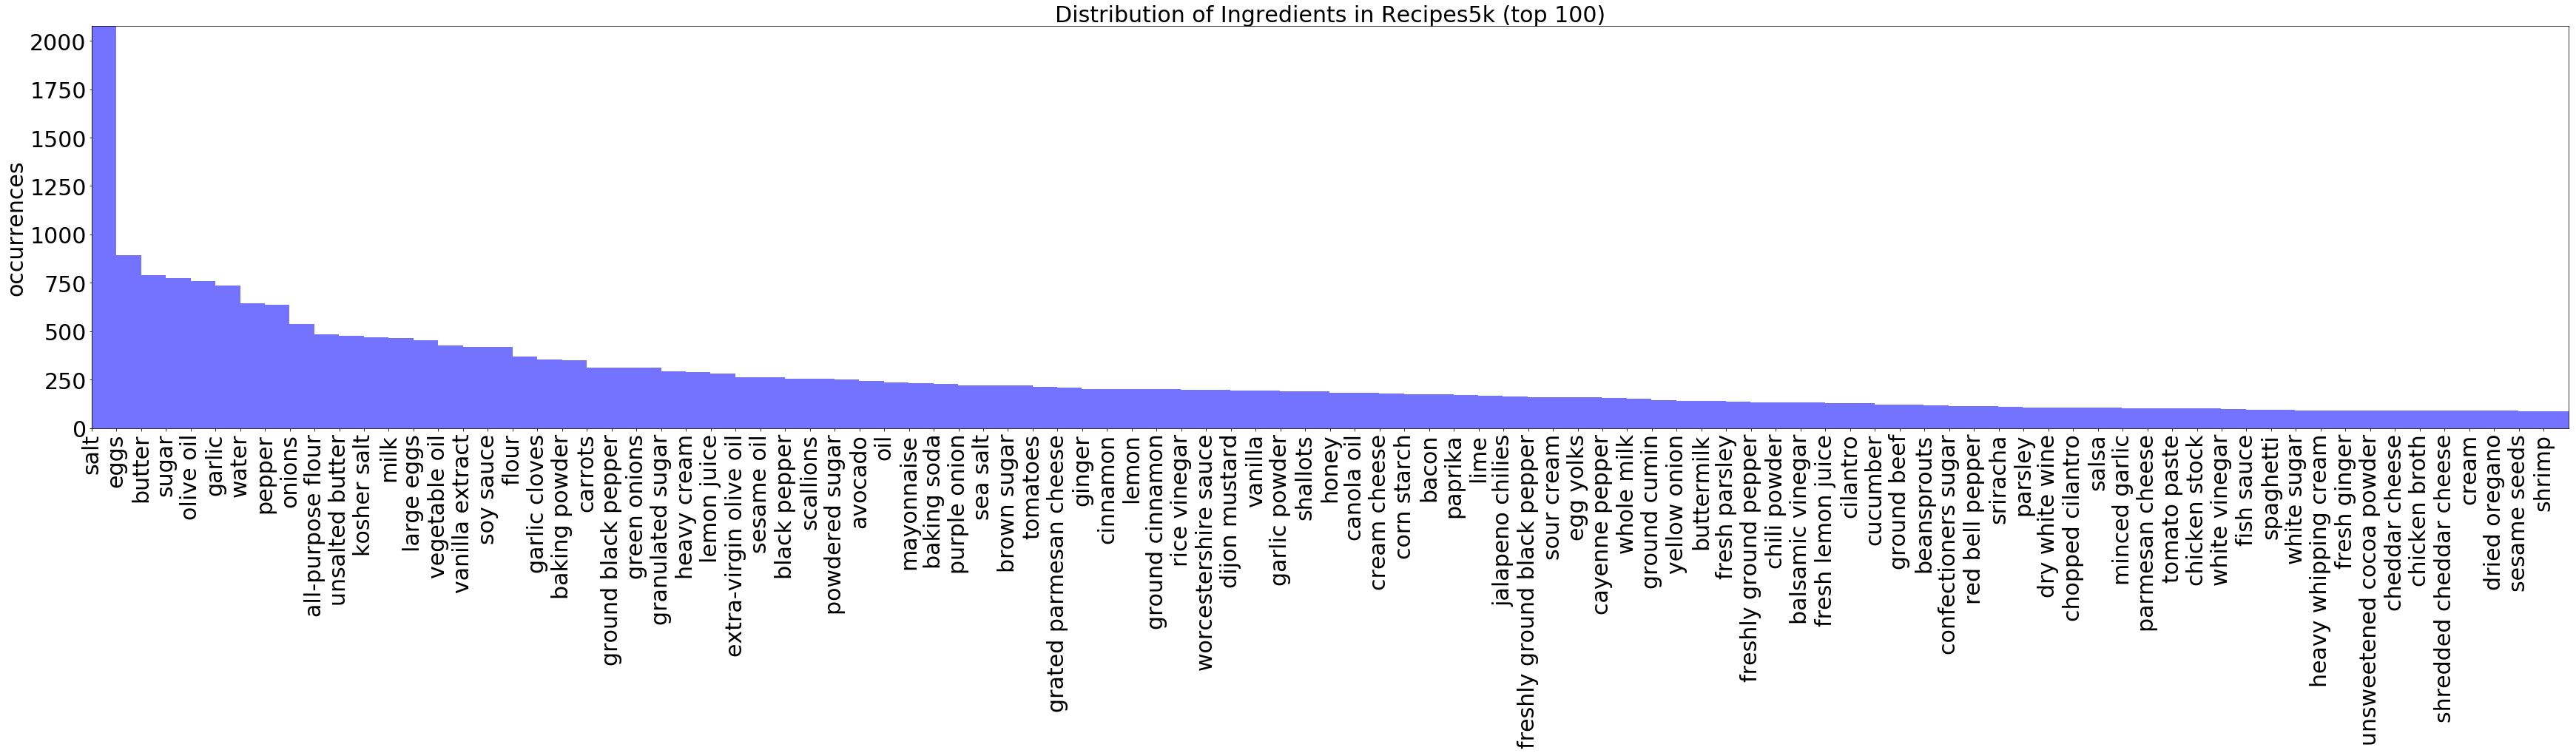

In [358]:
top_ing = 100
width = 60
height = 10

plotIngredientsHistogram(all_labels_idx_list, nbins=len(set_labels_list), 
                         title='Distribution of Ingredients in Recipes5k (top '+str(top_ing)+')',
                         max_val=int(max(counts)), show_max_ing=top_ing,
                         x_names=set_labels_list[:top_ing],
                         width=width, height=height, font_size=30)

## Plot ingredients distribution Recipes5k (cleaned)

In [363]:
all_labels = []
for s in ['train', 'val', 'test']:
    exec('lab = dataset_recipes5k.Y_'+s+'["'+params['OUTPUTS_IDS_DATASET'][0]+'"]')
    all_labels += lab

# raw2clean_mapping

word2idx = dataset_recipes5k.extra_variables['word2idx_binary']
idx2word = {v:k for k,v in word2idx.iteritems()}
    
all_labels_idx_list_clean = []
all_labels_list = []
for sample in all_labels:
    for i,l in enumerate(sample):
        if l:
            # Clean ingredients
            word = idx2word[i].strip()
            idx_clean = raw2clean_mapping[word]
            
            all_labels_idx_list_clean.append(idx_clean)
            all_labels_list.append(clean_ingredients_list[idx_clean])

set_labels_list_clean = list(set(all_labels_list))
counts_clean = np.zeros((len(set_labels_list_clean),)).astype(np.int)
for k in all_labels_idx_list_clean:
    counts_clean[k] += 1
    
idx_sort = [i[0] for i in sorted(enumerate(counts_clean), key=lambda x:x[1])][::-1]
set_labels_list_clean = [clean_ingredients_list[i] for i in idx_sort]

all_labels_idx_list_clean = []
for pos, idx in enumerate(idx_sort):
    all_labels_idx_list_clean += [pos for c in range(counts_clean[idx])]

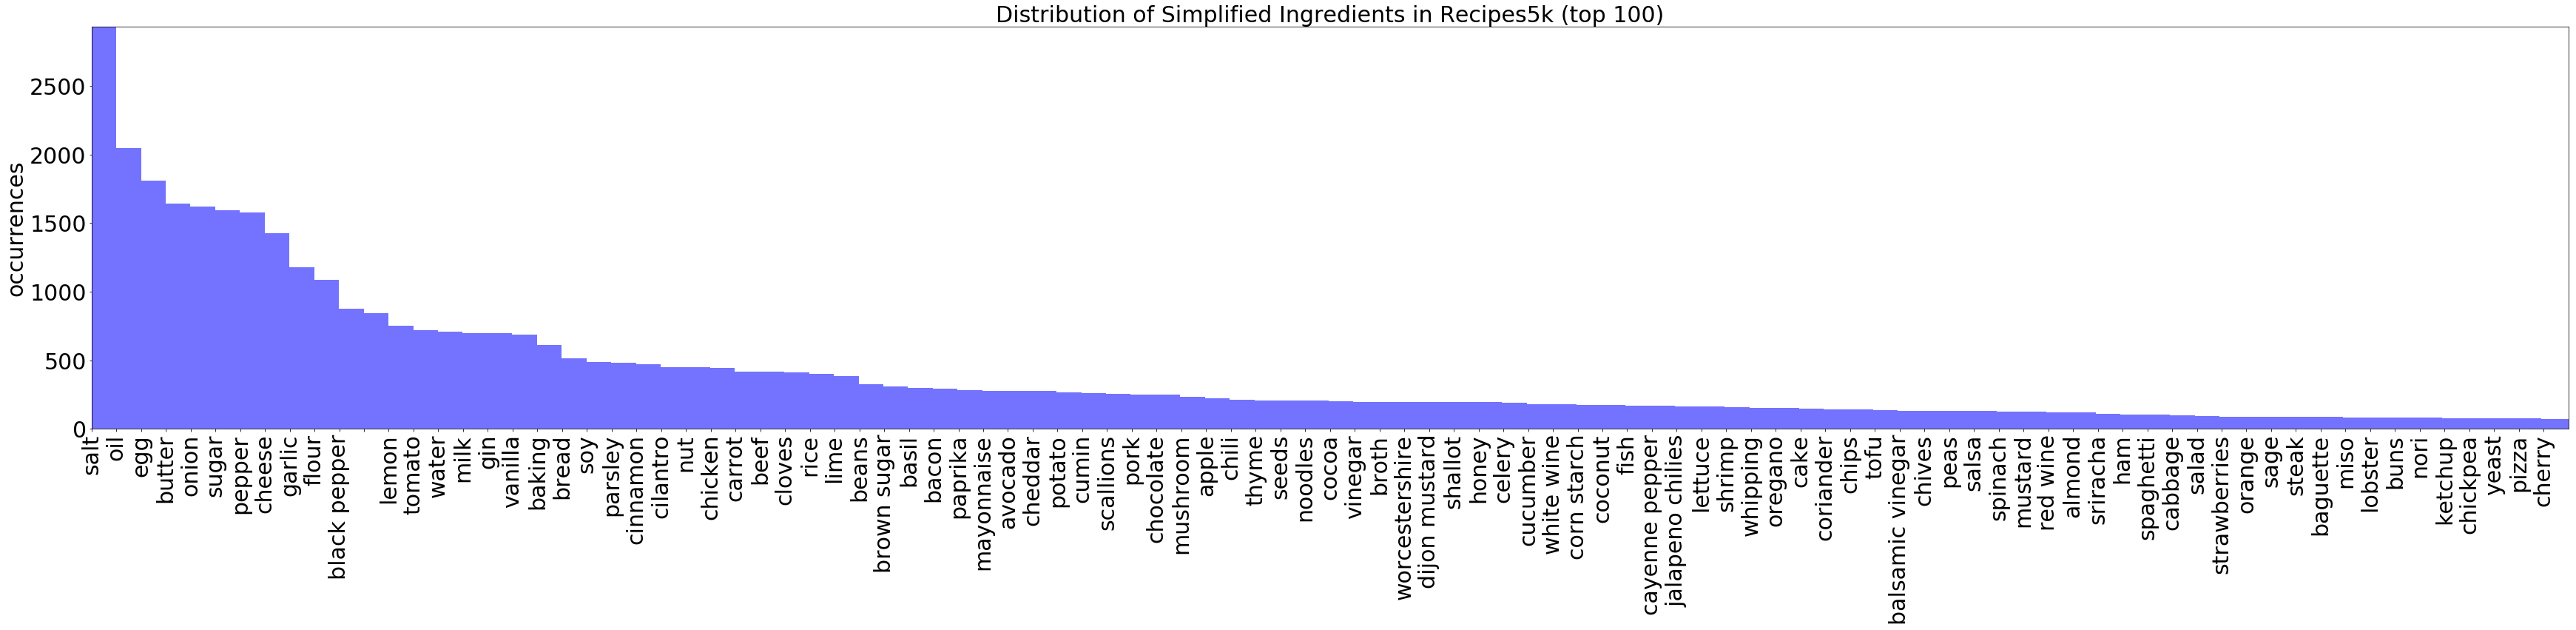

In [364]:
top_ing = 100
width = 60
height = 10

plotIngredientsHistogram(all_labels_idx_list_clean, nbins=len(set_labels_list_clean), 
                         title='Distribution of Simplified Ingredients in Recipes5k (top '+str(top_ing)+')',
                         max_val=int(max(counts_clean)), show_max_ing=top_ing,
                         x_names=set_labels_list_clean[:top_ing],
                         width=width, height=height, font_size=30)

## Plot ingredients distribution Ingredients101

In [365]:
all_labels = []
for s in ['train', 'val', 'test']:
    exec('lab = dataset.Y_'+s+'["'+params['OUTPUTS_IDS_DATASET'][0]+'"]')
    all_labels += lab

# raw2clean_mapping

word2idx = dataset.extra_variables['word2idx_binary']
idx2word = {v:k for k,v in word2idx.iteritems()}
    
all_labels_idx_list101 = []
all_labels_list = []
for sample in all_labels:
    for i,l in enumerate(sample):
        if l:
            all_labels_idx_list101.append(i)
            all_labels_list.append(idx2word[i])

set_labels_list101 = set(all_labels_list)
counts101 = np.zeros((len(set_labels_list101),)).astype(np.int)
for k in all_labels_idx_list101:
    counts101[k] += 1
    
idx_sort = [i[0] for i in sorted(enumerate(counts101), key=lambda x:x[1])][::-1]
set_labels_list101 = [idx2word[i] for i in idx_sort]

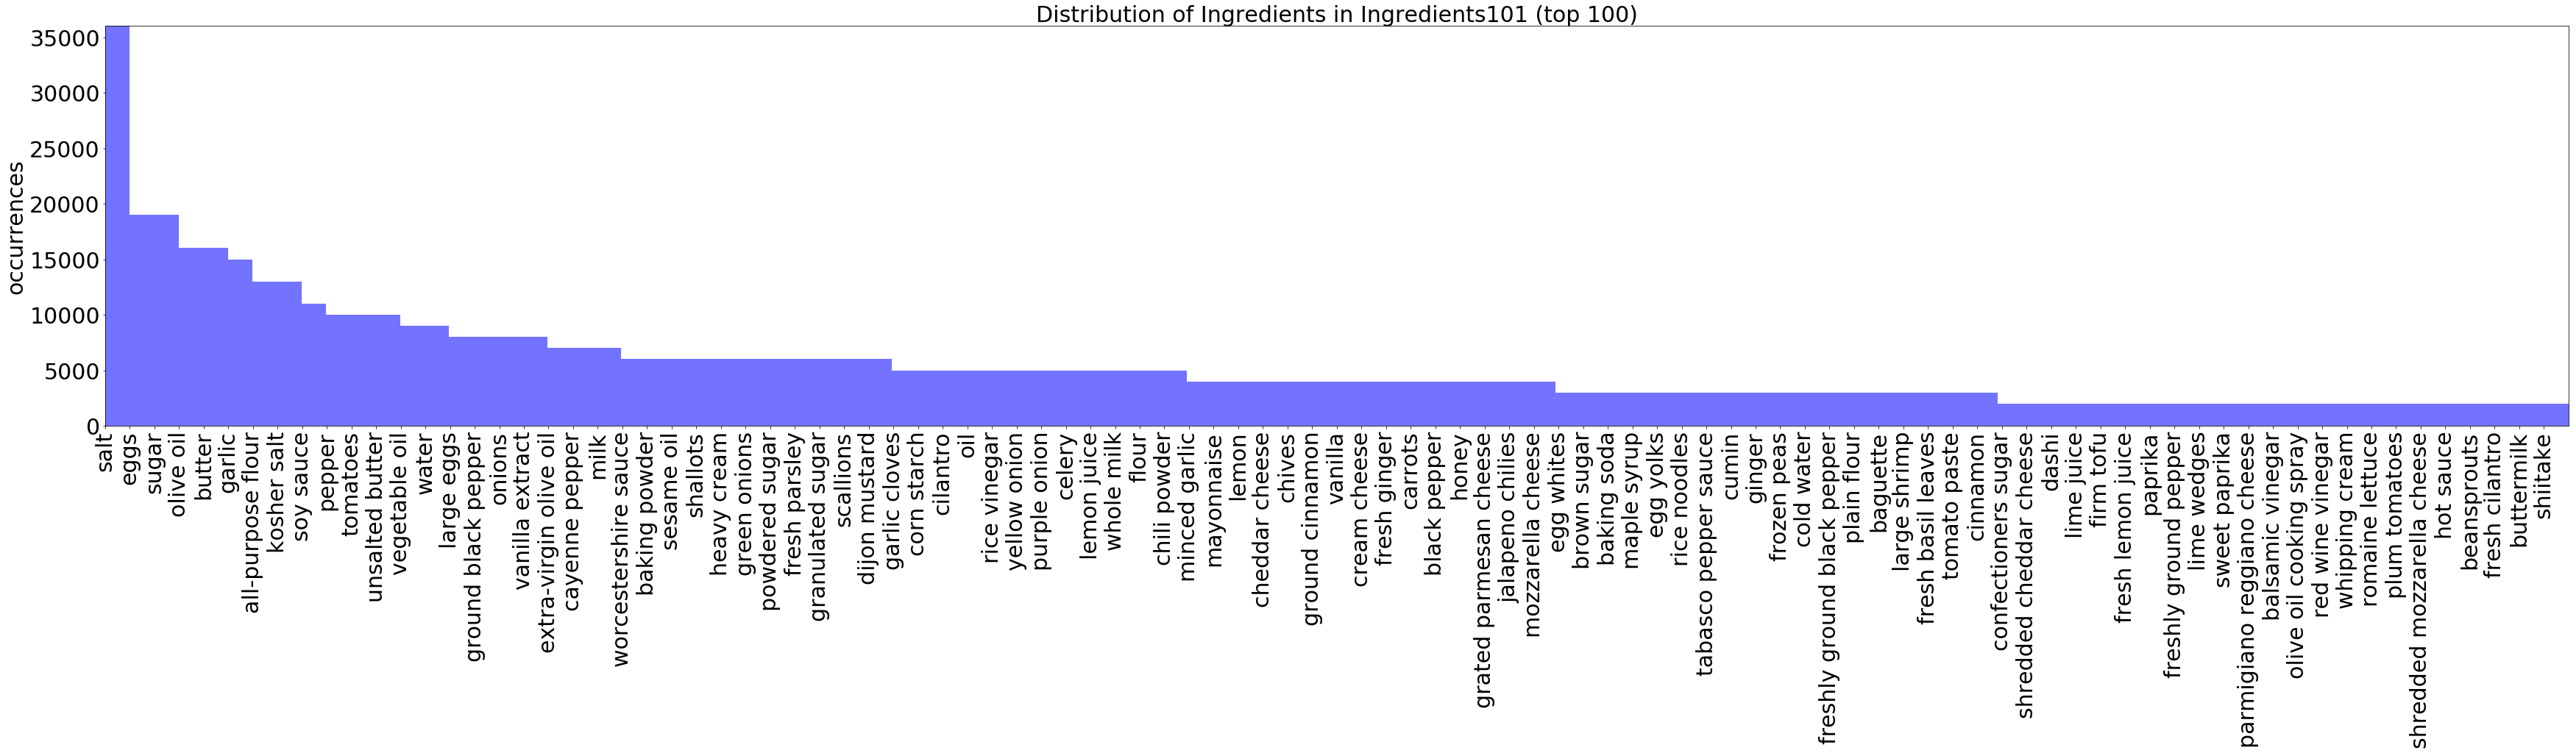

In [366]:
top_ing = 100
width = 60
height = 10

plotIngredientsHistogram(all_labels_idx_list101, nbins=len(set_labels_list101), 
                         title='Distribution of Ingredients in Ingredients101 (top '+str(top_ing)+')',
                         max_val=int(max(counts101)), show_max_ing=top_ing,
                         x_names=set_labels_list101[:top_ing],
                         width=width, height=height, font_size=30)

## PCA plot

In [526]:
from sklearn.decomposition import PCA
%autoreload 2

import pylab as Plot
from tsne_python import tsne

def extractFeatures(model, dataset, out_dim=2048, set_split='test', batch_size=10):
    
    exec('len_split = dataset.len_'+set_split)
    
    print len_split
    
    sample_imgs = range(len_split)
    activations = np.zeros((len_split, out_dim))
    labels = []
    
    # Load images in batches and calculate activations 
    for idx in range(0,len_split, batch_size):
        max_idx = min(idx+batch_size, len_split)
        current_samples = sample_imgs[idx:max_idx]
    
        # Load data
        [X, Y] = dataset.getXY_FromIndices(set_split, current_samples, dataAugmentation=False)
        [Xdeb, Ydeb] = dataset.getXY_FromIndices(set_split, current_samples, debug=True)
        
        # Predict activations
        y = model.predict(X)
        activations[idx:max_idx,:] = y
        
        # Store labels for plotting
        for name in Xdeb[0]:
            labels += [' '.join(name.split('/')[0].split('_'))]

    print activations.shape
    
    return activations, labels


In [527]:
first = model_recipes5k.model.get_layer('input_1').output
last = model_recipes5k.model.get_layer('flatten').output # 2048
#last = model_recipes5k.model.get_layer('ingredients').output # 3213
plot_model_recipes5k = Model(input=first, output=last)

y, labels = extractFeatures(plot_model_recipes5k, dataset_recipes5k, out_dim=2048, set_split='train')

3409
(3409, 2048)


In [502]:
epsilon = 0.000001
y_ = np.transpose(y)
y_norm = np.zeros(y_.shape)
for i,x in enumerate(y_):
    y_norm[i] = (x-min(x))/max(epsilon, (max(x)-min(x)))
y_norm = np.transpose(y_norm)

In [505]:
print y_norm.shape
Y = tsne.tsne(y_norm, no_dims=2, initial_dims=y.shape[1], perplexity=10.0)

(783, 3213)
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  783 ...
Computing P-values for point  500  of  783 ...
Mean value of sigma:  0.654675034434
Iteration  10 : error is  24.5444567787
Iteration  20 : error is  24.162947177
Iteration  30 : error is  25.8995916494
Iteration  40 : error is  25.1639387716
Iteration  50 : error is  23.9764748467
Iteration  60 : error is  24.8526489783
Iteration  70 : error is  23.5632504441
Iteration  80 : error is  24.4895868116
Iteration  90 : error is  25.2318665885
Iteration  100 : error is  24.1337773221
Iteration  110 : error is  4.0979846973
Iteration  120 : error is  3.42847357513
Iteration  130 : error is  3.03656578344
Iteration  140 : error is  2.81551105178
Iteration  150 : error is  2.74957274403
Iteration  160 : error is  2.68362714828
Iteration  170 : error is  2.63001944966
Iteration  180 : error is  2.55680108767
Iteration  190 : error is  2.28188265604
Iteration  200 : error 

In [533]:
unique_labels = list(set(labels))
col_labels = np.random.rand(len(unique_labels), 3)
col_plot = []
for l in labels:
    col_plot.append(col_labels[unique_labels.index(l)])

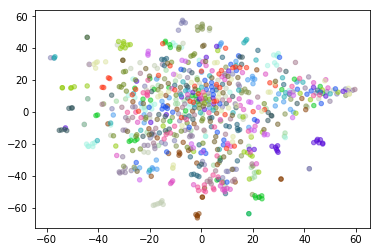

In [534]:
plt.scatter(Y[:,0], Y[:,1], 20, c=col_plot, alpha=0.5)#, labels)
plt.show()

In [535]:
y_pca = tsne.pca(y,no_dims=2).real

Preprocessing the data using PCA...


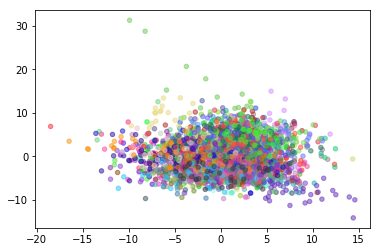

In [536]:
plt.scatter(y_pca[:,0], y_pca[:,1], 20, c=col_plot, alpha=0.5)#, labels)
plt.show()

In [537]:
first = model.model.get_layer('input_1').output
last = model.model.get_layer('flatten').output # 2048
#last = model_recipes5k.model.get_layer('ingredients').output # 3213
plot_model = Model(input=first, output=last)

y_ing101, labels_ing101 = extractFeatures(plot_model, dataset, out_dim=2048, set_split='test')

25250
(25250, 2048)


In [538]:
epsilon = 0.000001
y__ing101 = np.transpose(y_ing101)
y_norm_ing101 = np.zeros(y__ing101.shape)
for i,x in enumerate(y__ing101):
    y_norm_ing101[i] = (x-min(x))/max(epsilon, (max(x)-min(x)))
y_norm_ing101 = np.transpose(y_norm_ing101)

In [540]:
print y_norm_ing101.shape
Y_ing101 = tsne.tsne(y_norm_ing101, no_dims=2, initial_dims=y_ing101.shape[1], perplexity=10.0)

(25250, 2048)
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  25250 ...
Computing P-values for point  500  of  25250 ...
Computing P-values for point  1000  of  25250 ...
Computing P-values for point  1500  of  25250 ...
Computing P-values for point  2000  of  25250 ...
Computing P-values for point  2500  of  25250 ...
Computing P-values for point  3000  of  25250 ...
Computing P-values for point  3500  of  25250 ...
Computing P-values for point  4000  of  25250 ...
Computing P-values for point  4500  of  25250 ...
Computing P-values for point  5000  of  25250 ...
Computing P-values for point  5500  of  25250 ...
Computing P-values for point  6000  of  25250 ...
Computing P-values for point  6500  of  25250 ...
Computing P-values for point  7000  of  25250 ...
Computing P-values for point  7500  of  25250 ...
Computing P-values for point  8000  of  25250 ...
Computing P-values for point  8500  of  25250 ...
Computing P-values for

KeyboardInterrupt: 

In [ ]:
unique_labels_ing101 = list(set(labels_ing101))
col_labels_ing101 = np.random.rand(len(unique_labels_ing101), 3)
col_plot_ing101 = []
for l in labels_ing101:
    col_plot_ing101.append(col_labels_ing101[unique_labels_ing101.index(l)])

In [ ]:
plt.scatter(Y_ing101[:,0], Y_ing101[:,1], 20, c=col_plot_ing101, alpha=0.5)#, labels)
plt.show()